In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
import itertools

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
telemetry = pd.read_csv('./telemetry_cleaned.csv')
X = telemetry[['Easting', 'Northing', 'WaterDepth']].head(10000)
X.head(5)

,Easting,Northing,WaterDepth
0,0.158187,0.410159,92.93
1,0.158187,0.410159,5.86
2,0.534407,0.535898,5.86
3,0.534311,0.535924,6.33
4,0.533734,0.536254,7.02


### Baseline results

Using the parameters found in part 2, we can run a simple DBSCAN instance.

In [3]:
db = DBSCAN(eps=0.15, min_samples=9).fit(X)

We can then visualise this. Code from Sklearn documentation https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#plot-results

In [4]:
def plot_clusters(db, title, show_noise=True):
	unique_labels = set(db.labels_)
	core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
	core_samples_mask[db.core_sample_indices_] = True

	colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

	for k, color in zip(unique_labels, colors):
		if k == -1 and not show_noise:
			# Black used for noise
			color = [0, 0, 0, 1]
			continue

		class_member_mask = db.labels_ == k

		core_samples = X[class_member_mask & core_samples_mask]

		plt.plot(
			core_samples['Easting'],
			core_samples['Northing'],
			"o",
			markerfacecolor=tuple(color),
			markeredgecolor='k',
			markersize=10,
		)

		non_core_samples = X[class_member_mask & ~core_samples_mask]
		plt.plot(
			non_core_samples['Easting'],
			non_core_samples['Northing'],
			"o",
			markerfacecolor=tuple(color),
			markeredgecolor='k',
			markersize=3,
		)

	plt.title(f'{title} Clusters: {len(unique_labels)-1}, Noise: {list(db.labels_).count(-1)}')
	plt.show()

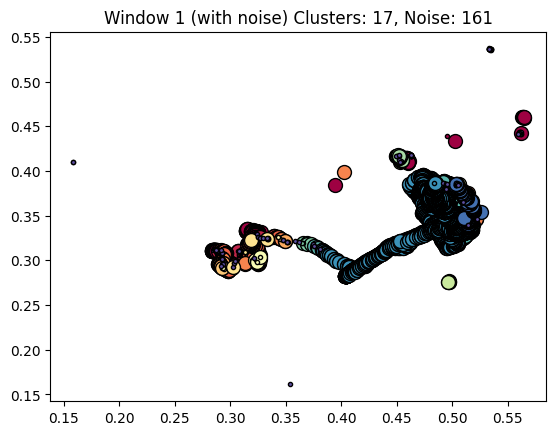

In [5]:
plot_clusters(db, 'Window 1 (with noise)')

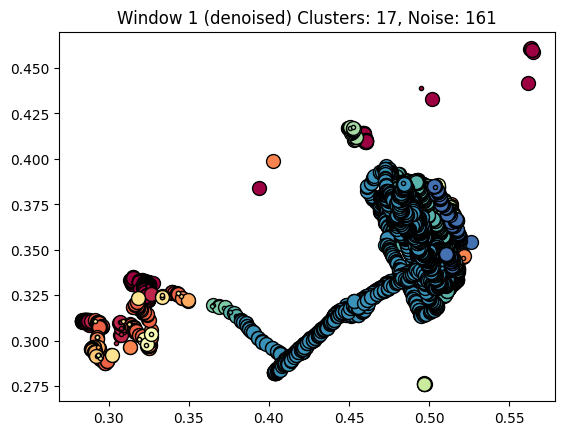

In [6]:
plot_clusters(db, 'Window 1 (denoised)', False)